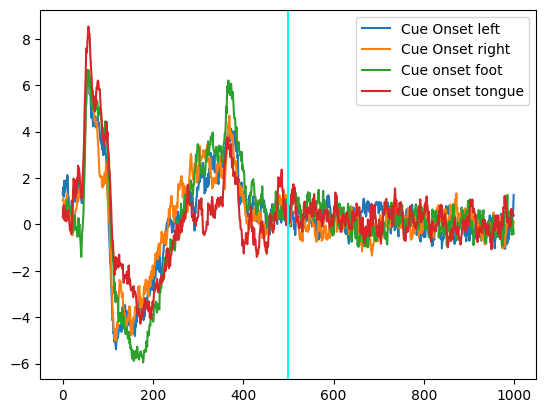

In [15]:
from keras.layers.reshaping.flatten import Flatten
from keras.layers.core.activation import Activation
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [16]:
def data_prep(X,y,sub_sample,average,noise,period):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:period]

    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_reshape = X.reshape(X.shape[0], X.shape[1], -1, sub_sample)
    X_max = np.max(X_reshape, axis=3)
    
    total_X = X_max
    total_y = y
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    if noise:
      X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))

    return total_X,total_y
        
def data_finalize(period, total_number, takeout_sample, y_test=y_test): 
    ind_valid = np.random.choice(total_number, takeout_sample, replace=False)  # get 375 out of 2115 samples and no repetitation
    ind_train = np.array(list(set(range(total_number)).difference(set(ind_valid)))) # a set(unordered) different with another set, set = set1 - set2

    # Creating the training and validation sets using the generated indices
    (X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
    (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
    x_train,y_train = data_prep(X_train,y_train,2,2,True, period=period)
    x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True, period=period)
    X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True, period=period)

    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test_prep, 4)

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)

    return x_train, x_valid, x_test, y_train, y_valid, y_test



X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,noise=True, period=500)


# **Train the model on subject 1 data only and test it on both subject 1 test set and all subject test set**

In [25]:
# get subject 1 data for training and validation set
person_train_valid = person_train_valid.flatten()
X_train_valid=X_train_valid[np.where(person_train_valid==0)]
y_train_valid=y_train_valid[np.where(person_train_valid==0)]

In [26]:
print(X_train_valid.shape)


(237, 22, 1000)


In [17]:
# Model parameters
learning_rate = 7e-4
epochs = 50
cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [18]:
x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=237, takeout_sample=42, period=1000, y_test=y_test)
# get subject 1 data for test set
person_test=person_test.flatten()
X_test_sub1 = x_test[np.where(person_test==0)]
y_test_sub1 = y_test[np.where(person_test==0)]

model_sub1 = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=25, kernel_size=(10,1), padding='same', activation=tf.nn.gelu, input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'), # Read the keras documentation
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=50, kernel_size=(10,1), padding='same', activation=tf.nn.gelu),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=100, kernel_size=(10,1), padding='same', activation=tf.nn.gelu),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation

  ])

  # Printing the model summary
model_sub1.summary()

  

model_sub1.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

  # Training and validating the model
model_sub1_results = model_sub1.fit(x_train,
              y_train,
              batch_size=32,
              epochs=50,
              validation_data=(x_valid, y_valid), verbose=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 500, 1, 25)        5525      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 250, 1, 25)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 250, 1, 25)       100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 250, 1, 25)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 1, 50)        12550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 125, 1, 50)       0

2023-03-17 15:20:09.756548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
25/25 [==============================] - 2s 55ms/step - loss: 2.0430 - accuracy: 0.3551 - val_loss: 3.3001 - val_accuracy: 0.2083
Epoch 2/50
25/25 [==============================] - 1s 45ms/step - loss: 1.5570 - accuracy: 0.4795 - val_loss: 2.4562 - val_accuracy: 0.2560
Epoch 3/50
25/25 [==============================] - 1s 45ms/step - loss: 1.1444 - accuracy: 0.5846 - val_loss: 1.8634 - val_accuracy: 0.3036
Epoch 4/50
25/25 [==============================] - 1s 45ms/step - loss: 0.8899 - accuracy: 0.6962 - val_loss: 1.7051 - val_accuracy: 0.2857
Epoch 5/50
25/25 [==============================] - 1s 51ms/step - loss: 0.7932 - accuracy: 0.7205 - val_loss: 1.8448 - val_accuracy: 0.3333
Epoch 6/50
25/25 [==============================] - 1s 55ms/step - loss: 0.6138 - accuracy: 0.7782 - val_loss: 2.0967 - val_accuracy: 0.3512
Epoch 7/50
25/25 [==============================] - 1s 50ms/step - loss: 0.5176 - accuracy: 0.7974 - val_loss: 2.3738 - val_accuracy: 0.3810
Epoch 8/50
25

In [19]:
cnn_score = model_sub1.evaluate(X_test_sub1, y_test_sub1, verbose=0)
print('Test accuracy of model_sub1:',cnn_score[1])

Test accuracy of model_sub1: 0.3799999952316284


In [20]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")
y_train_valid -= 769
y_test -= 769

In [19]:
for i in range(1000, 1100, 100):
    x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=i, y_test=y_test)
    print(x_train.shape)
    print(y_train.shape)
    print(x_valid.shape)
    print(y_valid.shape)
    print(x_test.shape)
    print(y_test.shape)
    model_all_subs = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=25, kernel_size=(10,1), padding='same', activation=tf.nn.gelu, input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'), 
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=50, kernel_size=(10,1), padding='same', activation=tf.nn.gelu),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=100, kernel_size=(10,1), padding='same', activation=tf.nn.gelu),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation

  ])

  # Printing the model summary
    model_all_subs.summary()

  

    model_all_subs.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

  # Training and validating the model
    model_all_subs_results = model_all_subs.fit(x_train,
              y_train,
              batch_size=32,
              epochs=epochs,
              validation_data=(x_valid, y_valid), verbose=True)


(6960, 500, 1, 22)
(6960, 4)
(1500, 500, 1, 22)
(1500, 4)
(1772, 500, 1, 22)
(1772, 4)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 500, 1, 25)        5525      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 250, 1, 25)       0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 250, 1, 25)       100       
 chNormalization)                                                
                                                                 
 dropout_24 (Dropout)        (None, 250, 1, 25)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 250, 1, 50)        12550     
                                 

In [32]:
cnn_score = model_all_subs.evaluate(X_test_sub1, y_test_sub1, verbose=0)
print('Test accuracy on one subjects:',cnn_score[1])

Test accuracy on one subjects: 0.5799999833106995


In [33]:
cnn_score = model_all_subs.evaluate(x_test, y_test, verbose=0)
print('Test accuracy on all subjects:',cnn_score[1])

Test accuracy on all subjects: 0.6450338363647461


In [43]:
print (X_test_sub1.shape)
print (y_test_sub1.shape)

(50, 500, 1, 22)
(50, 4)


## Train data based on time periods

In [12]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")
y_train_valid -= 769
y_test -= 769
print(y_train_valid.shape)
print(y_test.shape)

(2115,)
(443,)


In [27]:
short_time_train_scores = {}
short_time_test_scores = {}
for i in range(50, 550, 50):
    print("========== period:", i, " ==========")
    y_test = np.load("y_test.npy")
    y_test -= 769
    x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=i, y_test=y_test)

    model = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=25, kernel_size=(10,1), padding='same', activation=tf.nn.gelu, input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'), # Read the keras documentation
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=50, kernel_size=(10,1), padding='same', activation=tf.nn.gelu),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=100, kernel_size=(10,1), padding='same', activation=tf.nn.gelu),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation

  ])

    # Printing the model summary
    model.summary()

  

    model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

    # Training and validating the model
    model_results = model.fit(x_train,
                  y_train,
                  batch_size=32,
                  epochs=epochs,
                  validation_data=(x_valid, y_valid), verbose=True)

    short_time_train_scores[str(i)] = model.evaluate(x_train, y_train)[1]
    short_time_test_scores[str(i)] = model.evaluate(x_test, y_test)[1]
print(short_time_train_scores)
print(short_time_test_scores)

========== period: 50  ==========
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 25, 1, 25)         5525      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 13, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_36 (Bat  (None, 13, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_36 (Dropout)        (None, 13, 1, 25)         0         
                                                                 
 conv2d_37 (Conv2D)          (None, 13, 1, 50)         12550     
                                                                 
 max_pooling2d_37 (

218/218 [==============================] - 2s 9ms/step - loss: 0.8571 - accuracy: 0.6421 - val_loss: 1.1351 - val_accuracy: 0.5233
Epoch 27/50
218/218 [==============================] - 2s 9ms/step - loss: 0.8435 - accuracy: 0.6516 - val_loss: 1.1642 - val_accuracy: 0.4913
Epoch 28/50
218/218 [==============================] - 2s 8ms/step - loss: 0.8391 - accuracy: 0.6530 - val_loss: 1.1479 - val_accuracy: 0.5227
Epoch 29/50
218/218 [==============================] - 2s 8ms/step - loss: 0.8144 - accuracy: 0.6662 - val_loss: 1.1390 - val_accuracy: 0.5287
Epoch 30/50
218/218 [==============================] - 2s 9ms/step - loss: 0.8119 - accuracy: 0.6635 - val_loss: 1.1360 - val_accuracy: 0.5173
Epoch 31/50
218/218 [==============================] - 2s 9ms/step - loss: 0.8076 - accuracy: 0.6681 - val_loss: 1.2136 - val_accuracy: 0.4967
Epoch 32/50
218/218 [==============================] - 2s 9ms/step - loss: 0.8109 - accuracy: 0.6670 - val_loss: 1.1294 - val_accuracy: 0.5467
Epoch 33/50

Total params: 74,079
Trainable params: 73,729
Non-trainable params: 350
_________________________________________________________________
Epoch 1/50
218/218 [==============================] - 4s 16ms/step - loss: 1.9295 - accuracy: 0.3111 - val_loss: 1.3886 - val_accuracy: 0.3127
Epoch 2/50
218/218 [==============================] - 3s 15ms/step - loss: 1.4709 - accuracy: 0.3672 - val_loss: 1.2869 - val_accuracy: 0.3973
Epoch 3/50
218/218 [==============================] - 3s 15ms/step - loss: 1.3142 - accuracy: 0.4277 - val_loss: 1.2158 - val_accuracy: 0.4307
Epoch 4/50
218/218 [==============================] - 3s 15ms/step - loss: 1.2380 - accuracy: 0.4566 - val_loss: 1.2234 - val_accuracy: 0.4513
Epoch 5/50
218/218 [==============================] - 3s 15ms/step - loss: 1.1686 - accuracy: 0.4928 - val_loss: 1.1503 - val_accuracy: 0.4773
Epoch 6/50
218/218 [==============================] - 3s 15ms/step - loss: 1.1069 - accuracy: 0.5234 - val_loss: 1.1144 - val_accuracy: 0.5020
Epoc

                                                                 
 dropout_48 (Dropout)        (None, 63, 1, 25)         0         
                                                                 
 conv2d_49 (Conv2D)          (None, 63, 1, 50)         12550     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 32, 1, 50)        0         
 g2D)                                                            
                                                                 
 batch_normalization_49 (Bat  (None, 32, 1, 50)        200       
 chNormalization)                                                
                                                                 
 dropout_49 (Dropout)        (None, 32, 1, 50)         0         
                                                                 
 conv2d_50 (Conv2D)          (None, 32, 1, 100)        50100     
                                                                 
 max_pooli

218/218 [==============================] - 5s 21ms/step - loss: 0.4409 - accuracy: 0.8305 - val_loss: 0.9877 - val_accuracy: 0.6293
Epoch 32/50
218/218 [==============================] - 5s 21ms/step - loss: 0.4324 - accuracy: 0.8341 - val_loss: 1.0211 - val_accuracy: 0.6273
Epoch 33/50
218/218 [==============================] - 5s 22ms/step - loss: 0.4404 - accuracy: 0.8260 - val_loss: 0.9947 - val_accuracy: 0.6200
Epoch 34/50
218/218 [==============================] - 5s 22ms/step - loss: 0.4326 - accuracy: 0.8376 - val_loss: 1.0282 - val_accuracy: 0.6193
Epoch 35/50
218/218 [==============================] - 5s 22ms/step - loss: 0.4166 - accuracy: 0.8417 - val_loss: 1.0311 - val_accuracy: 0.6200
Epoch 36/50
218/218 [==============================] - 5s 22ms/step - loss: 0.4257 - accuracy: 0.8437 - val_loss: 1.0219 - val_accuracy: 0.6267
Epoch 37/50
218/218 [==============================] - 5s 22ms/step - loss: 0.4140 - accuracy: 0.8389 - val_loss: 0.9945 - val_accuracy: 0.6493
Epoc

218/218 [==============================] - 5s 23ms/step - loss: 0.5608 - accuracy: 0.7799 - val_loss: 0.9114 - val_accuracy: 0.6520
Epoch 19/50
218/218 [==============================] - 5s 23ms/step - loss: 0.5298 - accuracy: 0.7905 - val_loss: 0.9403 - val_accuracy: 0.6587
Epoch 20/50
218/218 [==============================] - 5s 23ms/step - loss: 0.5203 - accuracy: 0.7978 - val_loss: 0.9411 - val_accuracy: 0.6473
Epoch 21/50
218/218 [==============================] - 5s 23ms/step - loss: 0.5037 - accuracy: 0.7987 - val_loss: 0.9107 - val_accuracy: 0.6493
Epoch 22/50
218/218 [==============================] - 5s 23ms/step - loss: 0.4993 - accuracy: 0.8096 - val_loss: 0.9102 - val_accuracy: 0.6587
Epoch 23/50
218/218 [==============================] - 5s 23ms/step - loss: 0.4769 - accuracy: 0.8131 - val_loss: 0.8923 - val_accuracy: 0.6567
Epoch 24/50
218/218 [==============================] - 5s 23ms/step - loss: 0.4740 - accuracy: 0.8184 - val_loss: 0.9372 - val_accuracy: 0.6580
Epoc

218/218 [==============================] - 5s 24ms/step - loss: 1.0029 - accuracy: 0.5970 - val_loss: 1.1006 - val_accuracy: 0.5333
Epoch 6/50
218/218 [==============================] - 5s 24ms/step - loss: 0.9035 - accuracy: 0.6374 - val_loss: 1.0486 - val_accuracy: 0.5733
Epoch 7/50
218/218 [==============================] - 5s 25ms/step - loss: 0.8424 - accuracy: 0.6661 - val_loss: 1.0411 - val_accuracy: 0.5847
Epoch 8/50
218/218 [==============================] - 5s 25ms/step - loss: 0.8270 - accuracy: 0.6717 - val_loss: 0.9940 - val_accuracy: 0.6013
Epoch 9/50
218/218 [==============================] - 5s 25ms/step - loss: 0.7657 - accuracy: 0.6941 - val_loss: 0.9638 - val_accuracy: 0.6233
Epoch 10/50
218/218 [==============================] - 5s 25ms/step - loss: 0.7284 - accuracy: 0.7099 - val_loss: 0.9695 - val_accuracy: 0.6073
Epoch 11/50
218/218 [==============================] - 5s 25ms/step - loss: 0.7203 - accuracy: 0.7139 - val_loss: 0.9766 - val_accuracy: 0.6093
Epoch 12

 dropout_61 (Dropout)        (None, 57, 1, 50)         0         
                                                                 
 conv2d_62 (Conv2D)          (None, 57, 1, 100)        50100     
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 29, 1, 100)       0         
 g2D)                                                            
                                                                 
 batch_normalization_62 (Bat  (None, 29, 1, 100)       400       
 chNormalization)                                                
                                                                 
 dropout_62 (Dropout)        (None, 29, 1, 100)        0         
                                                                 
 flatten_20 (Flatten)        (None, 2900)              0         
                                                                 
 dense_20 (Dense)            (None, 4)                 11604     
          

218/218 [==============================] - 7s 32ms/step - loss: 0.2953 - accuracy: 0.8894 - val_loss: 0.8947 - val_accuracy: 0.7113
Epoch 37/50
218/218 [==============================] - 7s 32ms/step - loss: 0.2976 - accuracy: 0.8842 - val_loss: 0.8917 - val_accuracy: 0.6980
Epoch 38/50
218/218 [==============================] - 7s 32ms/step - loss: 0.2843 - accuracy: 0.8935 - val_loss: 0.9351 - val_accuracy: 0.7073
Epoch 39/50
218/218 [==============================] - 7s 32ms/step - loss: 0.2837 - accuracy: 0.8918 - val_loss: 0.9393 - val_accuracy: 0.6900
Epoch 40/50
218/218 [==============================] - 7s 32ms/step - loss: 0.2753 - accuracy: 0.8993 - val_loss: 0.9640 - val_accuracy: 0.7093
Epoch 41/50
218/218 [==============================] - 7s 32ms/step - loss: 0.2735 - accuracy: 0.8954 - val_loss: 0.9189 - val_accuracy: 0.7000
Epoch 42/50
218/218 [==============================] - 7s 31ms/step - loss: 0.2649 - accuracy: 0.9011 - val_loss: 0.9404 - val_accuracy: 0.6927
Epoc

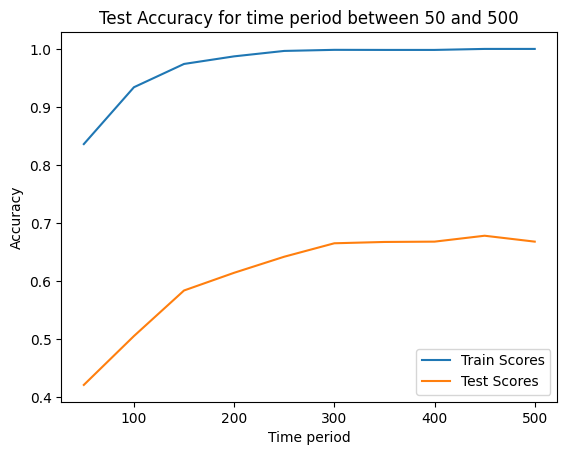

In [28]:
import matplotlib.pyplot as plt

# Create lists for x and y values
x_values = [int(k) for k in short_time_train_scores.keys()] # convert keys to integer values
train_scores = [v for v in short_time_train_scores.values()]
test_scores = [v for v in short_time_test_scores.values()]

# Plot the data
plt.plot(x_values, train_scores, label='Train Scores')
plt.plot(x_values, test_scores, label='Test Scores')

# Add labels and legend
plt.xlabel('Time period')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for time period between 50 and 500')
plt.legend()

# Show the plot
plt.show()

In [22]:
long_time_train_scores = {}
long_time_test_scores = {}
for i in range(600, 1100, 100):
    y_test = np.load("y_test.npy")
    y_test -= 769
    x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=i, y_test=y_test)

    model = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='relu', input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'), # Read the keras documentation
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='relu'),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='relu'),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation

  ])

  # Printing the model summary
    model.summary()

  

    model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

  # Training and validating the model
    model_results = model.fit(x_train,
              y_train,
              batch_size=32,
              epochs=epochs,
              validation_data=(x_valid, y_valid), verbose=True)

    long_time_train_scores[str(i)] = model.evaluate(x_train, y_train)[1]
    long_time_test_scores[str(i)] = model.evaluate(x_test, y_test)[1]
print(long_time_train_scores)
print(long_time_test_scores)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 300, 1, 25)        5525      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 150, 1, 25)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 150, 1, 25)       100       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 150, 1, 25)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 1, 50)        12550     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 1, 50)       

218/218 [==============================] - 6s 29ms/step - loss: 0.2644 - accuracy: 0.8980 - val_loss: 1.0358 - val_accuracy: 0.6720
Epoch 40/50
218/218 [==============================] - 6s 30ms/step - loss: 0.2582 - accuracy: 0.9022 - val_loss: 1.1116 - val_accuracy: 0.6607
Epoch 41/50
218/218 [==============================] - 6s 29ms/step - loss: 0.2629 - accuracy: 0.9019 - val_loss: 1.0375 - val_accuracy: 0.6747
Epoch 42/50
218/218 [==============================] - 6s 30ms/step - loss: 0.2533 - accuracy: 0.9026 - val_loss: 1.0947 - val_accuracy: 0.6520
Epoch 43/50
218/218 [==============================] - 6s 29ms/step - loss: 0.2624 - accuracy: 0.9001 - val_loss: 1.0419 - val_accuracy: 0.6700
Epoch 44/50
218/218 [==============================] - 6s 29ms/step - loss: 0.2496 - accuracy: 0.9059 - val_loss: 1.0510 - val_accuracy: 0.6767
Epoch 45/50
218/218 [==============================] - 6s 30ms/step - loss: 0.2212 - accuracy: 0.9194 - val_loss: 1.0740 - val_accuracy: 0.6780
Epoc

218/218 [==============================] - 7s 33ms/step - loss: 0.3601 - accuracy: 0.8674 - val_loss: 1.0681 - val_accuracy: 0.6153
Epoch 27/50
218/218 [==============================] - 7s 34ms/step - loss: 0.3624 - accuracy: 0.8634 - val_loss: 1.0260 - val_accuracy: 0.6360
Epoch 28/50
218/218 [==============================] - 7s 34ms/step - loss: 0.3420 - accuracy: 0.8675 - val_loss: 1.0554 - val_accuracy: 0.6247
Epoch 29/50
218/218 [==============================] - 7s 33ms/step - loss: 0.3317 - accuracy: 0.8772 - val_loss: 1.0408 - val_accuracy: 0.6520
Epoch 30/50
218/218 [==============================] - 7s 33ms/step - loss: 0.3267 - accuracy: 0.8783 - val_loss: 1.0668 - val_accuracy: 0.6440
Epoch 31/50
218/218 [==============================] - 7s 34ms/step - loss: 0.3213 - accuracy: 0.8777 - val_loss: 1.0281 - val_accuracy: 0.6533
Epoch 32/50
218/218 [==============================] - 7s 34ms/step - loss: 0.3133 - accuracy: 0.8777 - val_loss: 1.0027 - val_accuracy: 0.6627
Epoc

218/218 [==============================] - 8s 37ms/step - loss: 0.5821 - accuracy: 0.7726 - val_loss: 1.2112 - val_accuracy: 0.5560
Epoch 14/50
218/218 [==============================] - 8s 36ms/step - loss: 0.5427 - accuracy: 0.7845 - val_loss: 1.2094 - val_accuracy: 0.5573
Epoch 15/50
218/218 [==============================] - 8s 36ms/step - loss: 0.5333 - accuracy: 0.7888 - val_loss: 1.1447 - val_accuracy: 0.5807
Epoch 16/50
218/218 [==============================] - 8s 37ms/step - loss: 0.5035 - accuracy: 0.8033 - val_loss: 1.2029 - val_accuracy: 0.5700
Epoch 17/50
218/218 [==============================] - 8s 37ms/step - loss: 0.4981 - accuracy: 0.8086 - val_loss: 1.1771 - val_accuracy: 0.5540
Epoch 18/50
218/218 [==============================] - 8s 36ms/step - loss: 0.4733 - accuracy: 0.8185 - val_loss: 1.1095 - val_accuracy: 0.6193
Epoch 19/50
218/218 [==============================] - 8s 37ms/step - loss: 0.4384 - accuracy: 0.8320 - val_loss: 1.1470 - val_accuracy: 0.5907
Epoc

KeyboardInterrupt: 